# Task two

In task two we are looking at Pacific Sea Surface Temperature (SST) and local forecasts.
The two datasets we will be using for this are:

* the global SST data used in week four (1960-2016)
* the SST data recoreded at at Port Vila (Vanuatu) between 1993 and 2021.

The cross over period in the data is 1993-2016 so for the PC analysis used to develop the model we restrict ourselves to only these years.

We will use pricipal component (PC) analysis to develop a model based on a subset of the global SST data.
This subset of the global SST will contain the Pacific region around Port Vila Vanuatu.
To test the PC model we then try and predict the temperature recorded at the location chosen in the Pacific region and compare the outputs with the recorded data.

Vanuatu is located at $17 ^{\circ}45'S$ $168^{\circ} 18'E$.
The region we will look at for this task is centred at the equator.
I chose to look at $24^{\circ}S$ to $24^{\circ}N$ for latitude and $154^{\circ}E$ to $182^{\circ}E$ for longitude.
This region of the pacific comfortably contains the Port Vila measuring station.

## Part one

First we analyse the global SST data.
This data is **describe data here**.
Julia has a few things similar to python's `xarray` with the most developed one being `DimensionalData.jl`.
This has been used to create a package specific to spatial data called `GeoData.jl` which is what I will use.
The `GeoData.jl` package is designed to work with netCD4 data though I have run into some issues either some of the packages, the data, my coding (or all three) which meant I have had to alter the way I do things.
First set up the julia environment and load the required packages.

In [471]:
using Pkg
Pkg.activate("..")
using Plots, Statistics, Glob, Dates, GeoData, NCDatasets, LinearAlgebra

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


### Reading in SST data

The data is provided in the netCD4 format so this is firs read in using `NCDataset`.
I have cloned the [data repository](https://github.com/pangeo-data/tutorial-data) which contains all the data we looked at in lab 4 to my machine so there is no need to mount anything.
Instead just specify the file path and the create a vector containing the file names using the `glob` function.

In [472]:
SST_datapath = joinpath("../..", "globalSST/sst")
globalSST_data = glob(joinpath(SST_datapath, "*.nc"))
globalSST_file = NCDataset(globalSST_data; aggdim = "time")

NCDataset: ../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc…../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-2016.nc
Group: /

Dimensions
   lat = 89
   lon = 180
   time = 684

Variables
  lat   (89)
    Datatype:    Float32
    Dimensions:  lat
    Attributes:
     _FillValue           = NaN
     standard_name        = latitude
     pointwidth           = 2.0
     gridtype             = 0
     units                = degree_north

  lon   (180)
    Datatype:    Float32
    Dimensions:  lon
    Attributes:
     _FillValue           = NaN
     standard_name        = longitude
     pointwidth           = 2.0
     gridtype             = 1
     units                = degree_east

  sst   (180 × 89 × 684)
    Datatype:    Float32
    Dimensions:  lon × lat × time
    Attributes:
     _FillValue           = -999.0
     pointwidth           = 1.0
     valid_min            = -3.0
     valid_max            = 45.0
     units                = degree_Celsius
     long_name            = Extended reco

We can see that by reading in the data this way we get some information similar to `xarray` (though not as nicely laid out).
Now it is a matter of turning this `NCDataset` into a `GeoArray` so that all the features this package provides can be taken advantage of.
This is where I had some trouble.
The issue I have ran into was the `lat` and `lon` variables from the `NCDataset` were read in as unordered categorical arrays to the `GeoArray`.
This meant that plotting and choosing slices of data (by `lat` or `lon`) was not possible as it thought the numbers were categorical arrays.

After much trying the workaround I came up with was to create numeric vectors of the same length and stepsize as the `lat` and `lon` from the `NCDataset` then use these to create the `GeoArray`.
This does lose some information but I did make sure that the critical information was retained and if need be I can always refer back to the `NCDataset`.

Extract the data (SST) latitude, longitude and time from the `NCDataset`, then create new ordered numeric versions of the latitude and longitude.

In [504]:
timelength =  globalSST_file["time"][:]
sst =  globalSST_file["sst"]

#Create custom dimension types
@dim Lat YDim "Latitude (degrees north)"
@dim Lon XDim "Longitude (degrees east)"
#Create vectors that are the same size as the latitude and longitude in the data.
#I needed to do this because these arrays were being read as unordered categorical which could then not be plotted.
lon = 0:2:358
lat = -88:2:88
dimensions = (Lon(lon), Lat(lat), Ti(timelength))


  Lon (Longitude (degrees east)): 0:2:358,
  Lat (Latitude (degrees north)): -88:2:88,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]

Now we have the data and the dimensions we can generate the `GeoArray` and plot to see if it matches what we saw in lab 4.
We look at the full plot, the plot at zero latitude for the first observation (01/01/1960) then a time series of this over the whole data set.

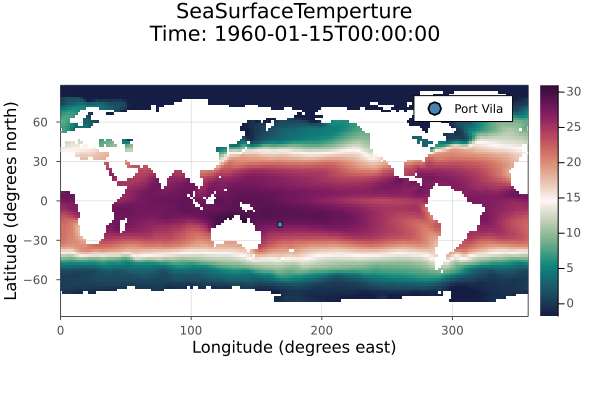

In [505]:
SSTglobal = GeoArray(sst, dimensions, name = :SeaSurfaceTemperture)
fullplot = SSTglobal[Ti(1)] |> plot
portvila_lat = findall(lat .== -18)
portvila_lon = findall(lon .== 168)
van_coords = (lon[portvila_lon], lat[portvila_lat])
scatter!(fullplot, van_coords, label = "Port Vila", color = :steelblue, m =:octagon, markersize = 3)

From this we can see that the plots are matching up with what we saw in lab 4 so all seems to be fine on the SST data front.
Now we select the region specified at the start and take a look at what it looks like.

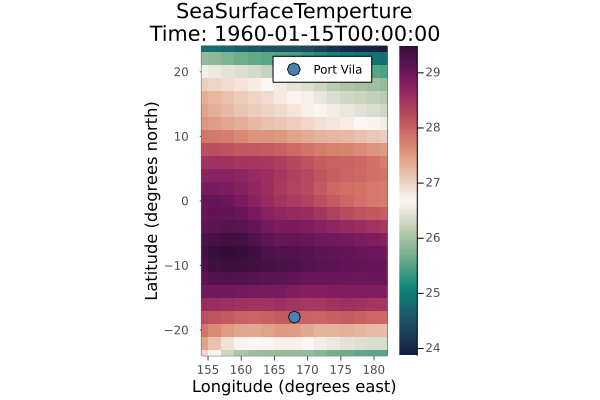

In [506]:
lonmin, lonmax = 154, 182
latmin, latmax = -24, 24
regionplot = plot(SSTglobal[Lon(Between(lonmin, lonmax)), Lat(Between(latmin, latmax)), Ti(1)])
scatter!(regionplot, van_coords, label = "Port Vila", color = :steelblue, m =:octagon, markersize = 6)

### Reading in data from the Pacific Sea Level Monitoring Project (PSLMP)

## Part two

First we note a difference in the plotting to `xarray`.
From the plots below of the one dimensional time series about the equator we can see that the plots are matching up with what we saw in lab 4 but the default plotting method is `Time` on the `xaxis`.
I will use the plotting provided by the `GeoData.jl` package (the one at the top above that has `Time` on the `xaxis`) for the rest of this task.

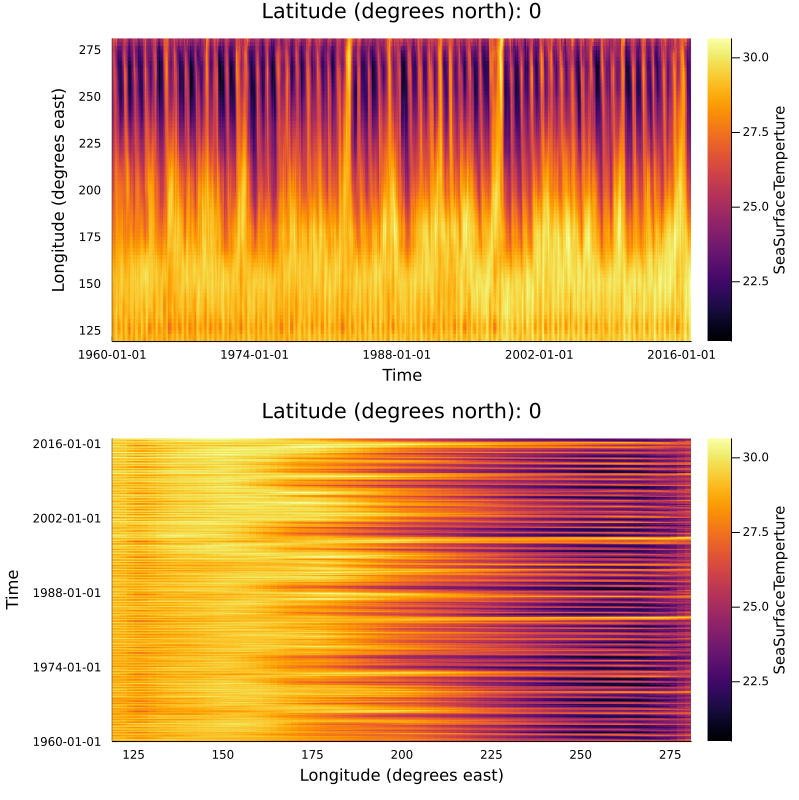

In [507]:
long_ts = SSTglobal[Lon(Between(120, 280)), Lat(At(0)), Ti()] 
plot1 = long_ts |> heatmap
plot2 = heatmap(120:2:280, timelength, long_ts', 
                title = "Latitude (degrees north): 0",
                xlabel = "Longitude (degrees east)",
                ylabel = "Time",
                colorbar_title  = "SeaSurfaceTemperture")
plot(plot1, plot2, size = (800, 800), layout = (2, 1))

### One dimensional SST reconstrcution from principal components

From the `SSTglobal` data we want to generate the anomaly.
This is computed in a simialr to the `xarray` package by taking the `mean` over the time dimension using the `GeoData.jl` package.

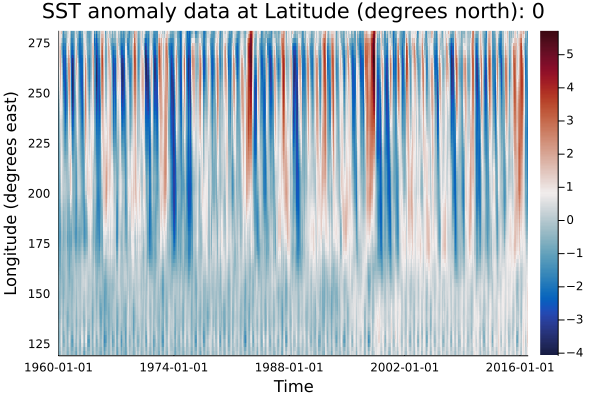

In [509]:
long_ts_mean = mean(long_ts, dims = Ti)
long_ts_mean = repeat(long_ts_mean, outer = (1, 684))
long_ts_anom = long_ts .- long_ts_mean
anom_plot = heatmap(long_ts_anom, color = :balance, title = "SST anomaly data at Latitude (degrees north): 0")

I now go through the lab 4 one dimensional reconstruction from the first principal component.
This is to both familiarise myself with the way the `GeoData.jl` package and check that I can correctly reproduce the lab 4 work before moving on to the 2D principal components.

Compute the covariance matrix and get the eigenvectors for form the principal components.
The covariance is computed for the longitude, so the dimension to get the covarince of is `Time`.

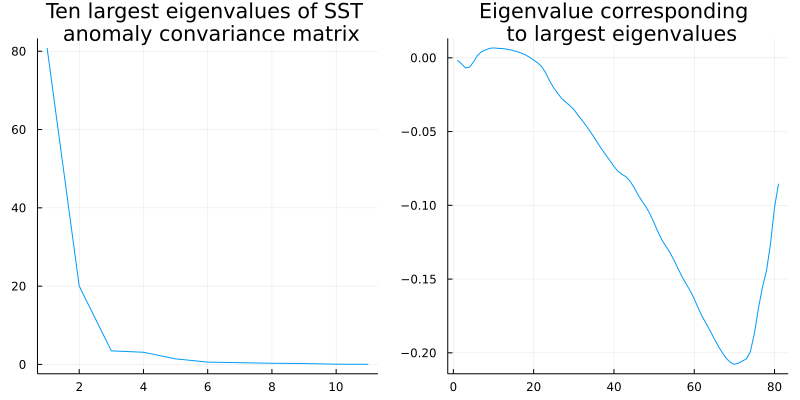

In [510]:
C_long_ts = cov(long_ts_anom, dims = Ti)
Cmat = reshape(C_long_ts[:], (81, 81)) #Turn this into a matrix to use with the `eigen` function.
Eigen_decomp_Cmat = eigen(Cmat)
plot(plot(Eigen_decomp_Cmat.values[end:-1:end-10], title = "Ten largest eigenvalues of SST \n anomaly convariance matrix", label = false),
    plot(Eigen_decomp_Cmat.vectors[:, end], title = "Eigenvalue corresponding \n to largest eigenvalues", label = false),
    layout = (1, 2), 
    size = (800, 400)
)

Now compute the first pricipal component $\mathbf{u}_{1}$.
This is done by multpliying the observations by the eigenvector corresponding to the largest eigenvalue, then summing this over the longitude dimension `Lon`

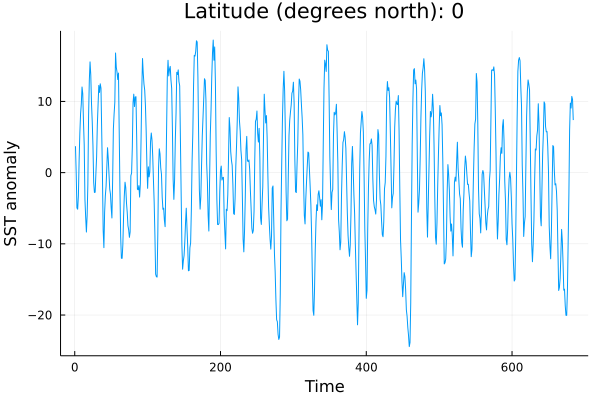

In [511]:
e₁ = Eigen_decomp_Cmat.vectors[:, end]
u₁ = sum(e₁ .* long_ts_anom; dims = Lon)
plot(u₁[:], label = false, xlabel = "Time", ylabel = "SST anomaly", title = "Latitude (degrees north): 0")

Now we reoconstruct the one dimensional time series for `long_ts_anom` (the SST anomaly) using the first principal component by

$$
\mathbf{x}' = \mathbf{e}_{1} ^{T} \mathbf{u}_{1}.
$$

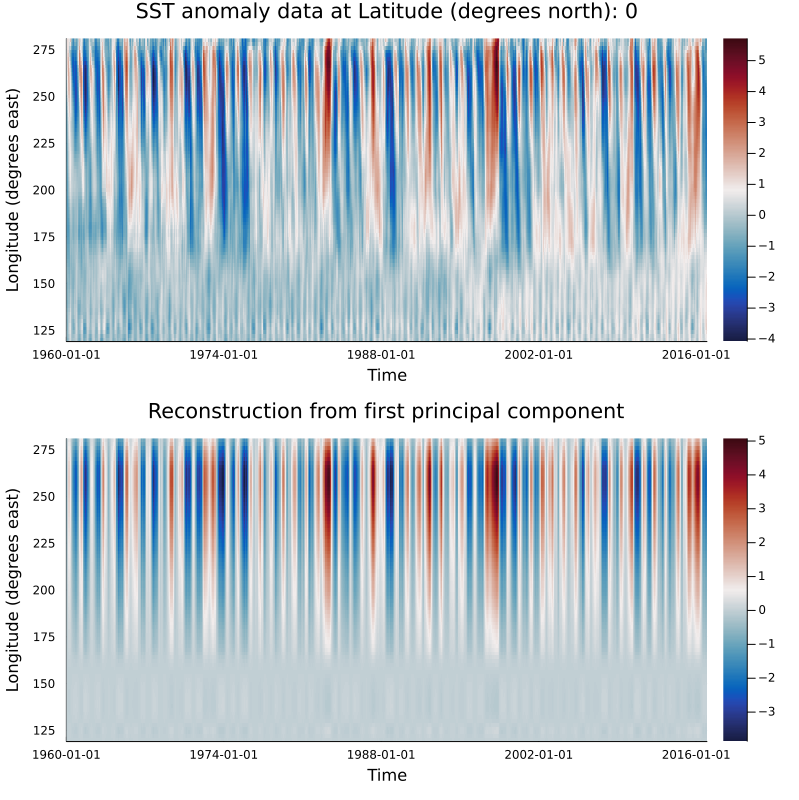

In [512]:
long_ts_anom_recon = e₁ .* u₁
long_ts_anom_recon = set(long_ts_anom_recon, Lon => 120:2:280) #Manually reset the number of Lon points to match the `long_ts_anom` data.
recon_plot = heatmap(long_ts_anom_recon, color = :balance, title = "Reconstruction from first principal component")
plot(anom_plot, recon_plot, size = (800, 800), layout = (2, 1))

### Two dimensional data reconstruction from principal components

To compute the two dimensional principal components we need to find the covariance between `Lat` and `Lon` dimensions along the time dimesions.
The section of data we will be doing this over is $25 ^{\circ}S$ to $25 ^{\circ}N$ for latitude and $152^{\circ}E$ to $184^{\circ}E$.
First extract this data from the full SST data and subtract the temporal mean to get the anomaly.

In [513]:
van_pac_sst = SSTglobal[Lon(Between(lonmin, lonmax)), Lat(Between(latmin, latmax))]
van_pac_mean = repeat(mean(van_pac_sst; dims = Ti), outer = (1, 1, 684))
vpsst_anom = van_pac_sst .- van_pac_mean

15×25×684 GeoArray{Float32,3} with dimensions: 
  Lon (Longitude (degrees east)): 154:2:182 Sampled: Ordered Regular Points,
  Lat (Latitude (degrees north)): -24:2:24 Sampled: Ordered Regular Points,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]
    Sampled: Ordered Irregular Points
with missingval: [:, :, 1]
 2.34956  2.19691  1.94757  1.69747   …  -1.31713  -1.5288   -1.84584
 2.22715  2.05308  1.82748  1.5969       -1.30629  -1.5077   -1.79757
 2.16464  2.00598  1.77673  1.51046      -1.29178  -1.51186  -1.81203
 2.13793  1.98381  1.73186  1.43622      -1.25659  -1.52387  -1.84139
 2.08818  1.93932  1.69055  1.37485      -1.26023  -1.5266   -1.84135
 2.0233   1.8584   1.62401  1.30603   …  -1.28873  -1.51764  -1.83741
 ⋮                                    ⋱                      
 1.79866  1.58182  1.31236  1.04972      -1.3551   -1.60608  -1.89961
 1.68493  1.47554  1.2358   1.01217   …  -1.37142  -1.64419  -1.96631
 1.59149  1.372    1.18983  0.995373     -1.3

missing


To calculate the covariance over the data, the matrix at each time step is reshaped into a vector.
The result is a new dimensional array that has all the `Lat`, `Lon` data (stacked on top of each other as all `Lat` values then all `Lon` values) in a vector for each time step.

In [514]:
reshape_vpsst = Array{Float32}(undef, 15*25, length(timelength))
for i ∈ 1:length(timelength[:])
    reshape_vpsst[:, i] = reshape(vpsst_anom[:, :, i], :)
end
vpsst_anom_reshape = GeoArray(reshape_vpsst, (X(1:375), Ti(timelength[:])))

375×684 GeoArray{Float32,2} with dimensions: 
  X: 1:375 Sampled: Ordered Regular Points,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]
    Sampled: Ordered Irregular Points
with missingval:   2.34956   2.81952   1.69019   0.796671  …  -0.349773   0.485567    1.36595
  2.22715   2.77265   1.68205   0.732903     -0.503218   0.323511    1.25665
  2.16464   2.76881   1.77826   0.743364     -0.723366   0.153364    1.13588
  2.13793   2.79169   1.91024   0.800734     -0.904202   0.0187359   1.02645
  2.08818   2.828     2.01218   0.869484     -0.989712  -0.089756    0.893042
  2.0233    2.87712   2.10105   0.963102  …  -1.02221   -0.197235    0.739767
  1.93823   2.85469   2.13593   1.03529      -1.05239   -0.277306    0.64723
  ⋮                                       ⋱                         
 -1.83066  -1.77403  -1.71578  -1.32623       1.96265    1.2372     -0.351732
 -1.89961  -1.82283  -1.7726   -1.31364       1.98184    1.13738    -0.4394
 -1.96631  -1.89601  -1.

missing


Then we can use the `cov` function to determine the covariance over the `Time` dimension as done in one dimension above.

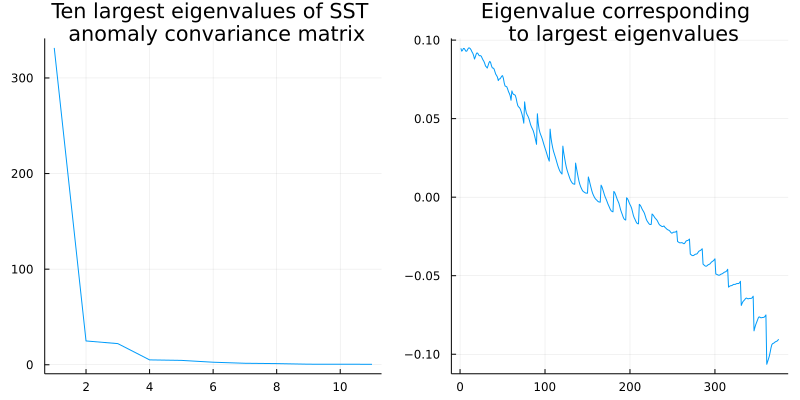

In [515]:
vpsst_cov = cov(vpsst_anom_reshape, dims = Ti)
vpsst_Cmat = reshape(vpsst_cov[:], (375, 375))
vpsst_eig = eigen(vpsst_Cmat)
plot(plot(vpsst_eig.values[end:-1:end-10], title = "Ten largest eigenvalues of SST \n anomaly convariance matrix", label = false),
    plot(vpsst_eig.vectors[:, end], title = "Eigenvalue corresponding \n to largest eigenvalues", label = false),
    layout = (1, 2), 
    size = (800, 400)
)

Looking at the eigenvalue plot by the time the fourth largest eigenvalue has been reached the size remains small, so we take the first four eigenvectors (associated with the four largest eignevalues) to form the principal component model.

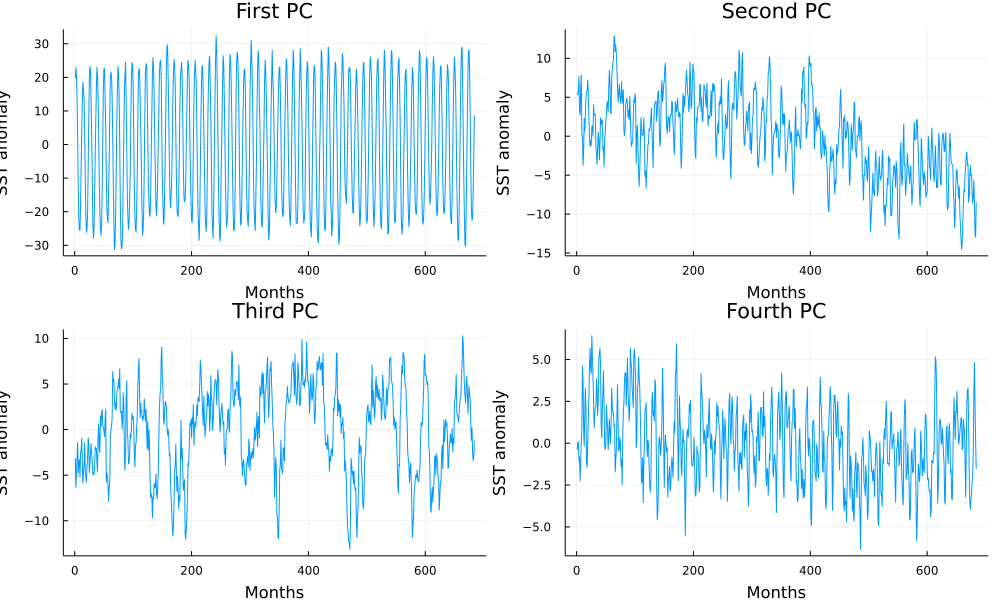

In [516]:
e₁ = vpsst_eig.vectors[:, end]
u₁ = sum(e₁ .* vpsst_anom_reshape; dims = X)
e₂ = vpsst_eig.vectors[:, end-1]
u₂ = sum(e₂ .* vpsst_anom_reshape; dims = X)
e₃ = vpsst_eig.vectors[:, end-2]
u₃ = sum(e₃ .* vpsst_anom_reshape; dims = X)
e₄ = vpsst_eig.vectors[:, end-3]
u₄ = sum(e₄ .* vpsst_anom_reshape; dims = X)
plot(plot(u₁[:], label = false, xlabel = "Months", ylabel = "SST anomaly", title = "First PC"),
    plot(u₂[:], label = false, xlabel = "Months", ylabel = "SST anomaly", title = "Second PC"),
    plot(u₃[:], label = false, xlabel = "Months", ylabel = "SST anomaly", title = "Third PC"),
    plot(u₄[:], label = false, xlabel = "Months", ylabel = "SST anomaly", title = "Fourth PC"),
size = (1000, 600), layout = (2, 2)
)

Now we can form the reconstructed data from the first four principal components.
The vectors containing the `Lat` and `Lon` values can be reshaped into the dimensions they had prior to turning them into a vector.
Then the SST at each gridpoint of (`Lat`, `Lon`) can be viewed as a time series.
We compare the original and reconstructed data for Port Vila.

In [517]:
vpsst_recon = e₁ .* u₁ + e₂ .* u₂ + e₃ .* u₃ + e₄ .* u₄
reshape_vpsst_recon = Array{Float32}(undef, 15, 25, length(timelength))
for i ∈ 1:length(timelength[:])
    reshape_vpsst_recon[:, :, i] = reshape(vpsst_recon[:, i], (15, 25))
end
dimensions_recon = (Lon(lonmin:2:lonmax), Lat(latmin:2:latmax), Ti(timelength))
full_vpsst_recon = GeoArray(reshape_vpsst_recon, dimensions_recon)

15×25×684 GeoArray{Float32,3} with dimensions: 
  Lon (Longitude (degrees east)): 154:2:182 Sampled: Ordered Regular Points,
  Lat (Latitude (degrees north)): -24:2:24 Sampled: Ordered Regular Points,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]
    Sampled: Ordered Irregular Points
with missingval: [:, :, 1]
 1.47465  1.4072   1.31532  1.20637  …  -1.40465  -1.72351  -2.16297
 1.48008  1.41756  1.34862  1.2378      -1.388    -1.68682  -2.13334
 1.54414  1.48678  1.41011  1.26974     -1.37708  -1.65094  -2.10092
 1.61548  1.55004  1.45818  1.29552     -1.36987  -1.61859  -2.05871
 1.66159  1.59801  1.49677  1.31398     -1.36343  -1.58913  -1.99695
 1.69896  1.64037  1.51982  1.30929  …  -1.35275  -1.56696  -1.9305
 ⋮                                   ⋱                      
 1.81064  1.72281  1.56545  1.31862     -1.40273  -1.57737  -1.86167
 1.81696  1.71127  1.54245  1.29152  …  -1.41291  -1.58573  -1.86175
 1.82048  1.70336  1.52002  1.25347     -1.43007  -1.60

missing


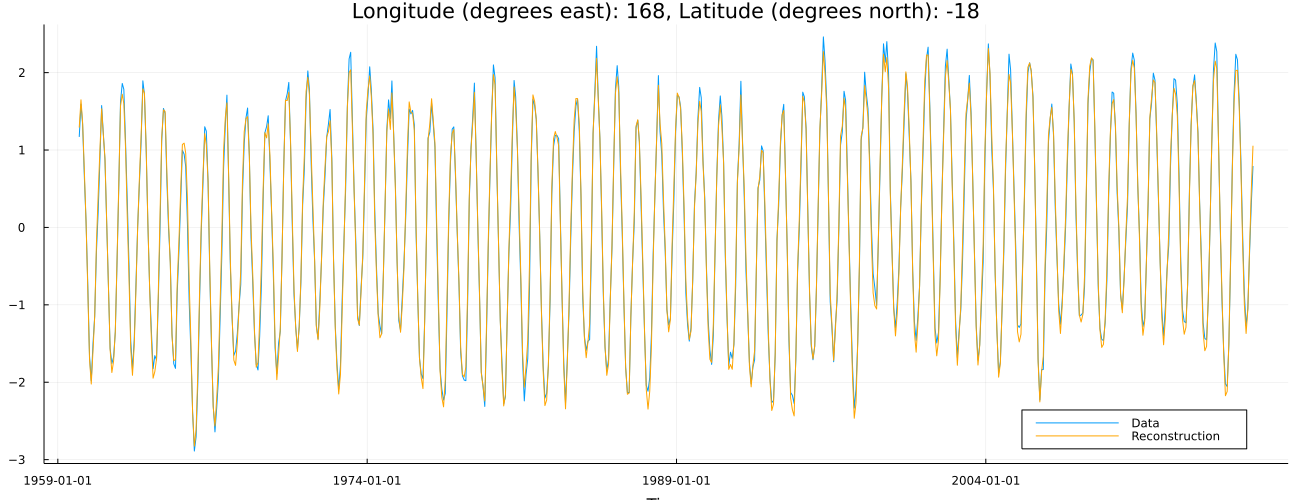

In [518]:
vpsst_data_plot = plot(vpsst_anom[Lon(At(168)), Lat(At(-18))], label = "Data", legend = :bottomright)
plot!(vpsst_data_plot, full_vpsst_recon[Lon(At(168)), Lat(At(-18))], color = :orange, label = "Reconstruction", size = (1300, 500))